### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

Пусть $a(x_i) = F(x_i) = f_0(x) + c_1f_1(x) + ... + c_nf_n(x)$

Тогда таргетом будет: $-\frac{dL}{dF}(x_i,F_{k-1}(x_i))$

Вычислим производную для каждого лосса:

1) $\frac{dL}{dF} = 2(F(x_i) - y_i)$

2) $\frac{dL}{dF} = exp( -F(x_i) y_i) * (-y_i)$

3) $\frac{dL}{dF} = \frac{exp( -F(x_i) y_i) * (-y_i)}{1 + exp( -F(x_i) y_i)}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [132]:
class MyGradientBoostingClassifier:

    def __init__(self, loss = "mse", learning_rate = 0.1, n_estimators = 100,
                 colsample = 1.0, subsample = 1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучении одного алгоритма
        subsample -- процент рандомных объектов при обучении одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.models = []
        
    def fit(self, X, y, base_model = DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.y = y
        F = np.mean(y) * np.ones([y.shape[0]])
        target = y
        if init_model is None:
            self.first = False
            model = base_model(*self.args, **self.kwargs)
        else:
            self.first = True
            model = init_model()
        model.fit(X, target)
        self.models.append(model)
        F += self.learning_rate * model.predict(X).reshape([X.shape[0]])
        for i in range(1, self.n_estimators):               
            if self.loss == 'mse':
                target = 2 * (y - F)
            if self.loss == 'exp':
                target = (np.exp(-F * y)) * y
            if self.loss == 'log':
                target = ((np.exp(-F * y)) * y) / (1 + np.exp(-F * y))
            model = base_model(*self.args, **self.kwargs)
            model.fit(X, target)
            self.models.append(model)
            F += self.learning_rate * model.predict(X).reshape([X.shape[0]])

                   
                   
    def predict(self, X):
        if self.first:
            pred = self.learning_rate * self.models[0].predict(X).reshape([X.shape[0]])
        else:
            pred = np.ones([X.shape[0]]) * np.mean(self.y)
        for i in range(1, self.n_estimators):
            pred += self.learning_rate * self.models[i].predict(X).reshape([X.shape[0]])
        return np.around(pred).astype(int)



In [133]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [134]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [135]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [85]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [86]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [88]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle =True)
mod_scores = []
for iters in range(1, 200, 10):
    clf = MyGradientBoostingClassifier(n_estimators = iters)
    indices = kf.split(X)
    scores = []
    for train_ind, test_ind in indices:
        clf.fit(X[train_ind], y[train_ind])
        scores.append(accuracy_score(y_true=y[test_ind], y_pred=clf.predict(X[test_ind])))
    mod_scores.append(np.mean(np.array(scores)))

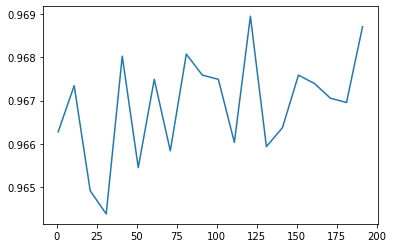

In [89]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,200, 10)),mod_scores)

In [96]:
kf = KFold(n_splits=5, shuffle=False)
best_res = 0
for loss in ['mse', 'exp', 'log']:
    clf = MyGradientBoostingClassifier(loss = loss)
    indices = kf.split(X)
    scores = []
    for train_ind, test_ind in indices:
        clf.fit(X[train_ind], y[train_ind])
        scores.append(accuracy_score(y_true=y[test_ind], y_pred=clf.predict(X[test_ind])))
    mean = np.mean(scores)
    if mean > best_res:
        print(mean)
        best_res = mean
        best_loss = loss



0.9637112403100776


In [97]:
best_loss

'mse'

In [102]:
kf = KFold(n_splits=5, shuffle=False)
best_res = 0
for rate in [0.1, 0.3, 0.5, 0.7, 0.9]:
    clf = MyGradientBoostingClassifier(learning_rate = rate)
    indices = kf.split(X)
    scores = []
    for train_ind, test_ind in indices:
        clf.fit(X[train_ind], y[train_ind])
        scores.append(accuracy_score(y_true=y[test_ind], y_pred=clf.predict(X[test_ind])))
    mean = np.mean(scores)
    if mean > best_res:
        print(mean)
        best_res = mean
        best_rate = rate

0.9629360465116278
0.9647771317829458
0.9653100775193799


In [103]:
best_rate

0.5

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [106]:
from sklearn.ensemble import RandomForestRegressor
my_clf = MyGradientBoostingClassifier(loss=best_loss, n_estimators_=120,
                                     learning_rate=best_rate)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
accuracy_score(y_test, my_clf.predict(X_test))

KeyboardInterrupt: 

In [108]:
from multiprocessing.dummy import Pool
from tqdm.notebook import tqdm
def process_random_boost(i):
    model = MyGradientBoostingClassifier()
    samples_inds = np.random.randint(0, X_train.shape[0], size=int(X_train.shape[0] / N))
    X_boost = X_train[samples_inds, :]
    y_boost = y_train[samples_inds]
    model.fit(X_boost, y_boost)
    preds = model.predict(X_test)
    with lock:
        boots_res.append(preds)
        pbar.update(1)
N = 70
with Pool(10) as pool, tqdm(N) as pbar:
    boots_res = []
    lock = pbar.get_lock()
    pool.map(process_random_boost, range(N))
pool.join()
print(accuracy_score(y_test, np.sum(boots_res, axis=0) / N > 0.5))

0it [00:00, ?it/s]

0.8575581395348837


## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X=X_train, y=y_train, init_model=LinearRegression)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.05555555555555555


In [130]:
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X=X_train, y=y_train, init_model=RandomForestRegressor)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.0


In [131]:
my_clf = MyGradientBoostingClassifier()
my_clf.fit(X=X_train, y=y_train, init_model=SVR)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.05555555555555555


Видимо в алгоритме ошибка, но уже не успеваю её исправить.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

